## GPU/CPU spectrogram plotting

In [1]:
import os
import torch #, torchvision
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from torch import istft
from scipy import signal
global GPU, n_fft, fft, eps
eps = 1e-15
GPU = 0
Fs = 1000000
n_fft = 1024
fft = 1024
plt.style.use('default')
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [22]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [2]:
path = "/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/Lora_mule/lora250/"
path2 = "/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/vodeson"
path3 = "/home/david/sigMF_ML/RF/ramdisk/"
path4 = "/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/YSF/"
os.chdir(path)
print(path)

/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/Lora_mule/lora250/


In [ ]:
saw_1msps_complex = np.fromfile(path_sawtooth_n210_new+"saw_test_1msps_n210.sigmf-data", np.complex64)
saw_5msps_complex = np.fromfile(path_sawtooth_n210_new+"saw_test_5msps_n210.sigmf-data", np.complex64)
saw_10msps_complex = np.fromfile(path_sawtooth_n210_new+"saw_test_10msps_n210.sigmf-data", np.complex64)
saw_25msps_complex = np.fromfile(path_sawtooth_n210_new+"saw_test_25msps_n210.sigmf-data", np.complex64)

In [ ]:
saw_1msps_no_carrier_complex = np.fromfile(path_sawtooth_n210_no_carrier+"saw_no_carrier.sigmf-data", np.complex64)
saw_1msps_no_carrier = np.fromfile(path_sawtooth_n210_no_carrier+"saw_no_carrier.sigmf-data", dtype="float32")

In [4]:
os.chdir(path3)
print(path3)
db3 = np.fromfile("test1.sigmf-data", dtype="float32")

/home/david/sigMF_ML/RF/ramdisk/


In [5]:
os.chdir(path)
print(path)
db = np.fromfile("lora250_test1.sigmf-data", dtype="float32")

/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/Lora_mule/lora250/


In [6]:
os.chdir(path2)
print(path2)
db2 = np.fromfile("UHF_vodeson_test1.sigmf-data", dtype="float32")

/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/vodeson


In [7]:
os.chdir(path4)
print(path4)
db4 = np.fromfile("UHF_YSF4_music_test1.sigmf-data", dtype="float32")

/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/YSF/


## For plotting ENTIRE spectrum: one sided MUST be false on torch.stft, becuase the actual signal CAN be on the negative frequency side. It just has not been for all my spectrum captures. I purposely put the signal of interest on the positive frequency side.

In [15]:
def gpu_test(db,msps,den):
    print('gpu_test live function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     den = 4
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w, window=win, center=True, normalized=True, onesided=False)

    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] - 1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[w//2:],X_stft[:w//2])) 
    print('X shape =', X_stft.shape)
    
    I_mag = torch.abs(torch.sqrt(I_stft[:,:,0]**2+I_stft[:,:,1]**2))
    Q_mag = torch.abs(torch.sqrt(Q_stft[:,:,0]**2+Q_stft[:,:,1]**2))      
    I_mag = torch.unsqueeze(I_mag, dim=2)
    Q_mag = torch.unsqueeze(Q_mag, dim=2)  
    
    Z_stft = torch.cat((I_mag,Q_mag),2)
    print('gpu_test live IQ shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:]))
#     Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    return Z_stft, X_stft # Returning 2D and plot

#### scipy CPU stft function for reference

In [9]:
def cpu(db):
    t = len(db)
    db2 = db[0::]
    db = db.astype(np.float32).view(np.complex64)
    I_t, I_f, Z = signal.stft(db, fs=Fs, nperseg=n_fft, return_onesided=False)
    Z = np.vstack([Z[n_fft//2:], Z[:n_fft//2]])
    return Z

## GPU plot

In [17]:
IQ, plot = gpu_test(db,1,4)

gpu_test live function
X shape = torch.Size([1024, 39063])
gpu_test live IQ shape = torch.Size([1024, 39063, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([1024, 39063, 2])


In [11]:
plot.shape

torch.Size([1024, 19532])

In [12]:
t1 = 20*np.log10(np.abs(IQ[:,:,0].cpu()+eps))
t2 = 20*np.log10(np.abs(plot.cpu()+eps))                

In [13]:
os.chdir(path)
print(path)
# db = np.fromfile("lora250_test1.sigmf-data", dtype="float32")
s1 = np.fromfile('lora250_test1.sigmf-data', np.complex64)
os.chdir(path2)
print(path2)
s2 = np.fromfile("UHF_vodeson_test1.sigmf-data", np.complex64)

/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/Lora_mule/lora250/
/home/david/sigMF_ML/RF/sigMF data collect_train_val_test/vodeson


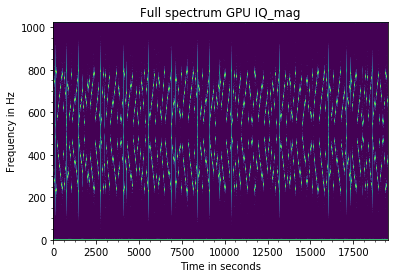

In [14]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()

# plt.imshow(20*np.log10(np.abs(plot.cpu()+eps)), aspect='auto', origin='lower')

plt.imshow(t1, vmin=-70, vmax=5, aspect='auto', origin='lower')
title = "Full spectrum GPU IQ_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_IQ_mag.pdf', format="pdf")
plt.show()

$\omega_{L O} = 2 \pi f_{L O}$, where: $L O$ is the frequency of the local oscillator in the SDR


To get the desired output, I must first swap the bottom 1/2 of the arrays with the top after the STFT. Then using the following equation:

$$
\begin{aligned}
x(t) e^{j \omega_{L O} t} &=\left(x_{I}(t)+j x_{Q}(t)\right)\left(\cos \left(\omega_{L O} t\right)+j \sin \left(\omega_{L O} t\right)\right) \\
&=x_{I}(t) \cos \left(\omega_{L O} t\right)-x_{Q}(t) \sin \left(\omega_{L O} t\right)+j\left(x_{Q}(t) \cos \left(\omega_{L O} t\right)+x_{I}(t) \sin \left(\omega_{L O} t\right)\right)
\end{aligned}
$$


Proceeding of the SDR 03 Technical Conference and Product Exposition. Copyright © 2003 SDR Forum. All Rights Reserved

Then using notebook code notation, and re-arranging the equation:

$$
\begin{aligned}
x(t) e^{j \omega_{L O} t} &=I_{0}(t) \cos \left(\omega_{L O} t\right) +I_{1}(t) \sin \left(\omega_{L O} t\right) -Q_{0}(t) \sin \left(\omega_{L O} t\right)+Q_{1}(t) \cos \left(\omega_{L O} t\right)
\end{aligned}
$$

simplified for this notebook would be:

$$\begin{aligned} I_{0} + I_{1} - Q_{0} + Q_{1}  \end{aligned}$$

However, for some reason, I have to combine the channels in the following fashion to get a comparable signals.stft cpu representation of the spectrum:

$$\begin{aligned} I_{0} + I_{1} + Q_{0} - Q_{1}  \end{aligned}$$

then for the proper spectrogram; $ 20 log10\left(\lvert I_{0} + I_{1} + Q_{0} - Q_{1}\lvert\right)$



## GPU combination of IQ channels for spectrogram

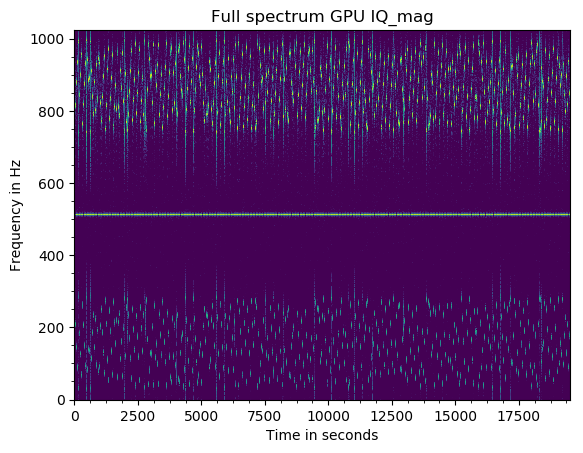

In [42]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()

plt.imshow(t2, vmin=-70, vmax=5, aspect='auto', origin='lower')

# plt.imshow(20*np.log10(IQ[:,:,0].cpu()+1e-8), aspect='auto', origin='lower')
title = "Full spectrum GPU IQ_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_IQ_mag.pdf', format="pdf")
plt.show()

## CPU plot

In [43]:
stft_cpu = cpu(db)

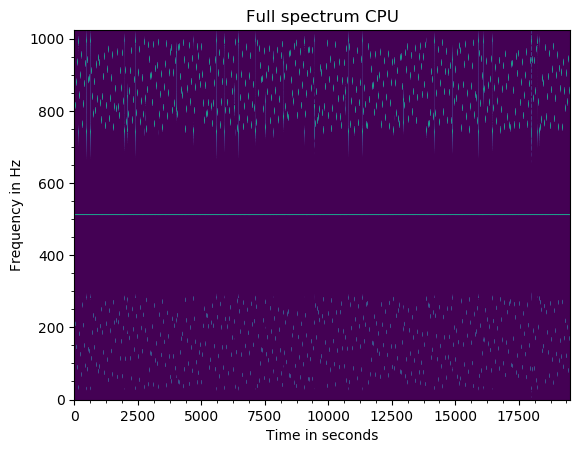

In [44]:
plt.figure(figsize=(9, 6))
fig6 = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_cpu+eps)), vmin=-70, vmax=5, aspect='auto', origin='lower')
title = "Full spectrum CPU"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig6.savefig('full_spectrum_cpu.pdf', format="pdf")
plt.show()

## other plots using various channels and combinations

In [45]:
def gpu_plot(db):
    I = db[0::2]
    Q = db[1::2]
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    I_stft2 = torch.cat((I_stft[n_fft//2:,:],I_stft[:n_fft//2,:])) # swap bottom with top of array
    Q_stft2 = torch.cat((Q_stft[n_fft//2:,:],Q_stft[:n_fft//2,:])) # swap bottom with top of array
#     X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    I_mag = torch.sqrt(I_stft2[:,:,0]**2+I_stft2[:,:,1]**2)
    Q_mag = torch.sqrt(Q_stft2[:,:,0]**2+Q_stft2[:,:,1]**2)
#     IQ_mag = torch.sqrt(I_mag[:,:]**2+Q_mag[:,:]**2)
    IQ_mag = torch.sqrt((I_stft2[:,:,0]**2+I_stft2[:,:,1]**2)+(Q_stft2[:,:,0]**2+Q_stft2[:,:,1]**2))
    torch.cuda.empty_cache()
    return I_stft2, Q_stft2, I_mag, Q_mag, IQ_mag

In [46]:
I, Q, I_mag, Q_mag, IQ_mag = gpu_plot(db)

In [47]:
# I, Q, I_mag, Q_mag, IQ_mag = gpu_plot(db2)

In [48]:
I.shape, Q.shape, I_mag.shape, Q_mag.shape, IQ_mag.shape

(torch.Size([1024, 19532, 2]),
 torch.Size([1024, 19532, 2]),
 torch.Size([1024, 19532]),
 torch.Size([1024, 19532]),
 torch.Size([1024, 19532]))

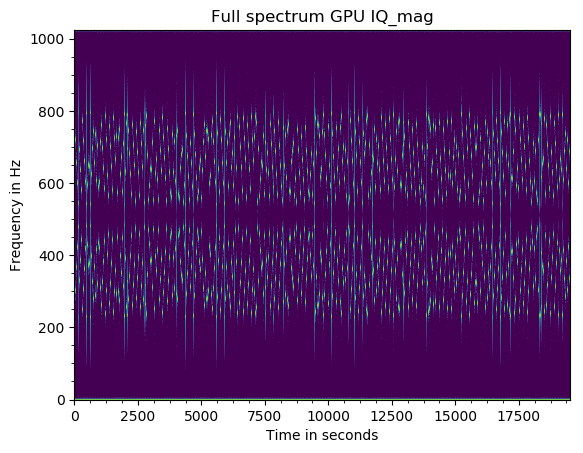

In [49]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()
# plt.imshow(20*np.log10(np.abs((I_mag.cpu()+Q_mag.cpu())+1e-8)), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(I_mag.cpu()+1e-8), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(Q_mag.cpu()+1e-8), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(IQ_mag.cpu()+1e-8), aspect='auto', origin='lower')

# plt.imshow(20*np.log10(np.abs(plot.cpu()+eps)), aspect='auto', origin='lower')

plt.imshow(20*np.log10(IQ[:,:,0].cpu()+1e-8), vmin=-70, vmax=5, aspect='auto', origin='lower')
title = "Full spectrum GPU IQ_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_IQ_mag.pdf', format="pdf")
plt.show()

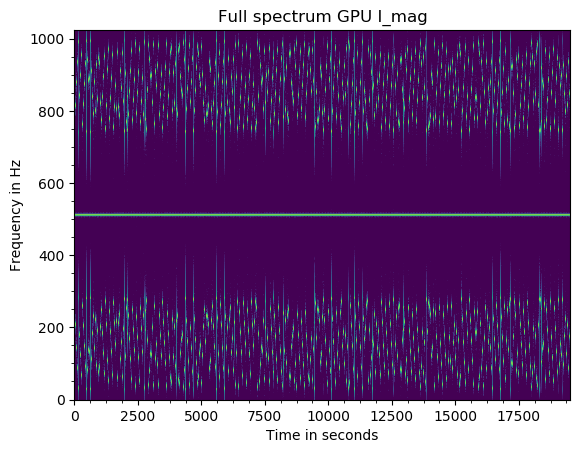

In [50]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()
# plt.imshow(20*np.log10(np.abs((I_mag.cpu()+Q_mag.cpu())+1e-8)), aspect='auto', origin='lower')
plt.imshow(20*np.log10(I_mag.cpu()+1e-8), vmin=-70, vmax=5, aspect='auto', origin='lower')
# plt.imshow(20*np.log10(Q_mag.cpu()+1e-8), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(IQ_mag.cpu()+1e-8), aspect='auto', origin='lower')
title = "Full spectrum GPU I_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_I_mag.pdf', format="pdf")
plt.show()

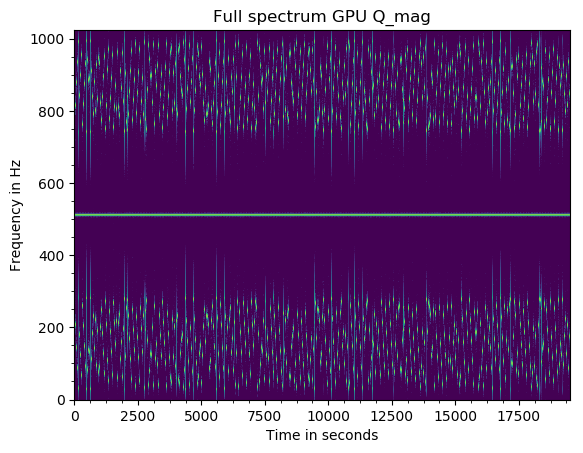

In [51]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()
# plt.imshow(20*np.log10(np.abs((I_mag.cpu()+Q_mag.cpu())+1e-8)), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(I_mag.cpu()+1e-8), aspect='auto', origin='lower')
plt.imshow(20*np.log10(Q_mag.cpu()+1e-8), vmin=-70, vmax=5, aspect='auto', origin='lower')
# plt.imshow(20*np.log10(IQ_mag.cpu()+1e-8), aspect='auto', origin='lower')
title = "Full spectrum GPU Q_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_Q_mag.pdf', format="pdf")
plt.show()

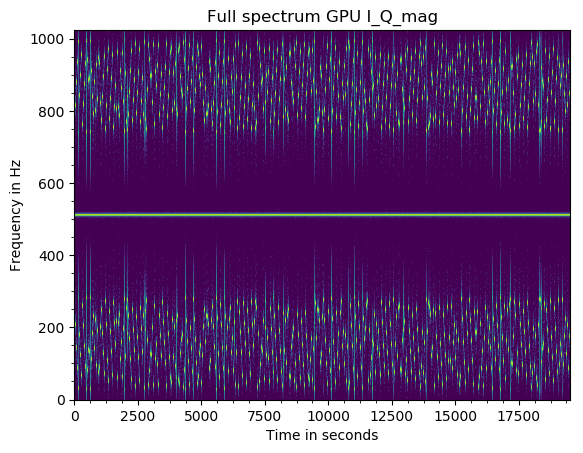

In [52]:
plt.figure(figsize=(9, 6))
fig1 = plt.figure()
plt.imshow(20*np.log10(np.abs((I_mag.cpu()+Q_mag.cpu())+1e-8)), vmin=-70, vmax=5, aspect='auto', origin='lower')
# plt.imshow(20*np.log10(I_mag.cpu()+1e-8), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(Q_mag.cpu()+1e-8), aspect='auto', origin='lower')
# plt.imshow(20*np.log10(IQ_mag.cpu()+1e-8), aspect='auto', origin='lower')
title = "Full spectrum GPU I_Q_mag"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig1.savefig('full_spectrum_gpu_I_Q_mag.pdf', format="pdf")
plt.show()

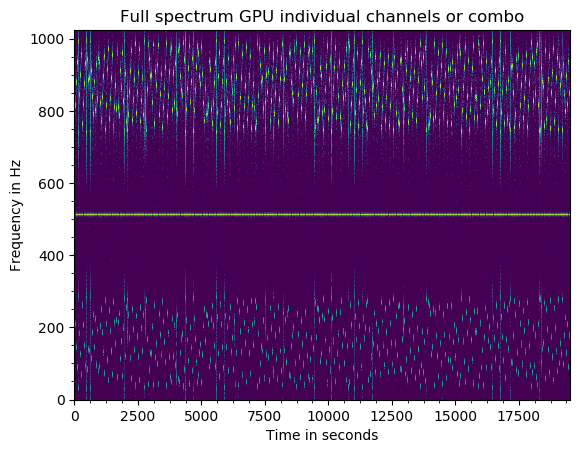

In [53]:
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
# trying different combos of I/Q channels     I2[:,:,0]+Q2[:,:,0]+I2[:,:,1]-Q2[:,:,1]
plt.imshow(20*np.log10(np.abs((I[:,:,0]+Q[:,:,0]+I[:,:,1]-Q[:,:,1]).cpu()+1e-8)), vmin=-70, vmax=5, aspect='auto', origin='lower')
title = "Full spectrum GPU individual channels or combo"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig2.savefig('full_spectrum_gpu_I0.pdf', format="pdf")
plt.show()

## Digital Constellation for Yeasu 4FSK. Symbols seem uniformly distributed in donut

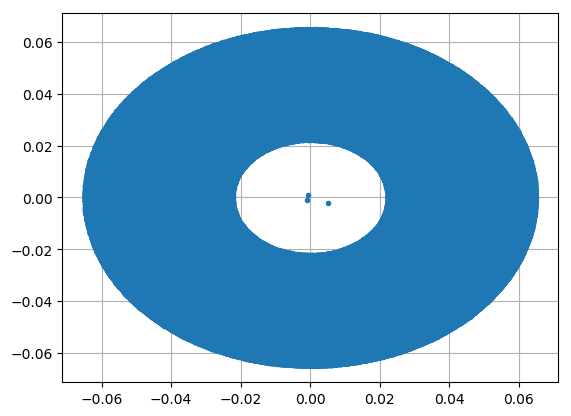

In [56]:
# Plot constellation of YSF digital modulation (4FSK type) for comparison WITH NON-DIGITAL constallation
t3 = db4[0::]
t4 = t3.astype(np.float32).view(np.complex64)

plt.figure(figsize=(9, 6))
fig1 = plt.figure()
plt.plot(np.real(t4), np.imag(t4), '.')
plt.grid(True)
# plt.xlim([-.02, .02])
# plt.ylim([-.02, .02])
plt.show()

## Analog Constellation - FMCW LoRa no symbols in analog domain

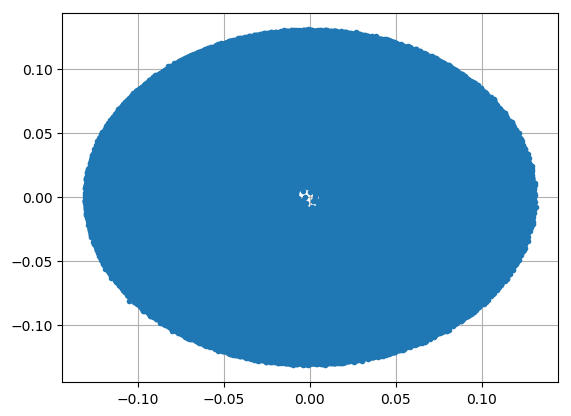

In [57]:
# Plot constellation of LoRa modulation (fmcw type) NO EXPECTATION OF DEFINED CONSTALLATION
t5 = db[0::]
t6 = t5.astype(np.float32).view(np.complex64)

plt.figure(figsize=(9, 6))
fig1 = plt.figure()
plt.plot(np.real(t6), np.imag(t6), '.')
plt.grid(True)
# plt.xlim([-.02, .02])
# plt.ylim([-.02, .02])
plt.show()